In [1]:
import torch
from torchvision.models import VisionTransformer
import torch.nn as nn
import pickle
import os
import numpy as np
import pandas as pd
from adic_components.prototype2 import P2ECDEC
import tqdm
%pip install loguru
from loguru import logger
import sys
import torch
# allow all messages
logger.remove()
logger_id = logger.add(sys.stderr, level="TRACE", colorize=True, format="<level>{level}</level>: {message} | {name}:{function}:{line} | {time:HH:mm:ss DD-MM-YYYY}")
IN_COLAB = 'google.colab' in sys.modules
logger.info("Colab? : {}", IN_COLAB)
if IN_COLAB:
  logger.info("Mounitng Google drive")
  from google.colab import drive
  drive.mount('/content/drive')
logger.info("Python version: {}", sys.version)
logger.info("Torch version: {}", torch.__version__)
logger.info("Cuda available? : {}", torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info("Running on {}", device)
%env KAGGLEHUB_CACHE=datasets
import kagglehub
import os
logger.info("Importing dataset to {}", os.environ["KAGGLEHUB_CACHE"])
path = kagglehub.dataset_download("nikhil7280/coco-image-caption")
logger.info("Path to dataset files:", path)
import sys
logger.remove(logger_id)
logger_id = logger.add(sys.stderr, level="WARNING", colorize=True, format="<level>{level}</level>: {message} | {name}:{function}:{line} | {time:HH:mm:ss DD-MM-YYYY}")

INFO: Colab? : False | __main__:<module>:18 | 18:16:53 16-04-2025
INFO: Python version: 3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0] | __main__:<module>:23 | 18:16:53 16-04-2025
INFO: Torch version: 2.6.0+cpu | __main__:<module>:24 | 18:16:53 16-04-2025
INFO: Cuda available? : False | __main__:<module>:25 | 18:16:53 16-04-2025


Note: you may need to restart the kernel to use updated packages.


INFO: Running on cpu | __main__:<module>:27 | 18:16:53 16-04-2025


env: KAGGLEHUB_CACHE=datasets


INFO: Importing dataset to datasets | __main__:<module>:31 | 18:16:53 16-04-2025


INFO: Path to dataset files: | __main__:<module>:33 | 18:16:55 16-04-2025


In [2]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config
from adic_components.prototype2 import P2GPTBlock
from adic_components.prototype3 import P3ECDEC, P3Decoder
from adic_components.DyT import DyT
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
gpt2_model_pretrained = GPT2Model.from_pretrained('gpt2')
# Get model config to know vocab size and hidden size
config = GPT2Config.from_pretrained('gpt2')
vocab_size = config.vocab_size
hidden_size = config.n_embd
gpt2_model = P2GPTBlock(config)
gpt2_model.load_state_dict(gpt2_model_pretrained.state_dict(), strict=False)
decoder = P3Decoder(config)
decoder.gpt2_model = gpt2_model
encodeco = P3ECDEC(3, 224, 224, hidden_size, decoder)
weights = torch.load("checkpoint_3.pth", map_location=device)
model = encodeco
model.load_state_dict(weights)

<All keys matched successfully>

In [ ]:
from torch.utils.data import DataLoader, Subset
from adic_components.CaptionsDataset import CaptionDataset, default_transform
import random
import os

# Create dataset and dataloader
dataset_sampling = CaptionDataset(
    images_dir=os.path.join(path, 'train2014/train2014'),
    json_path=os.path.join(path, 'annotations_trainval2014/annotations/captions_train2014.json'),
)

/mnt/1EC2AF28C2AF035F/fac/M1/IP/aiimgdetect/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


A skateboarder in a black shirt and hat jumping over a construction sign.
['A man riding a skateboard down a ramp.             a skate']
Meteor score:  0.1851851851851852


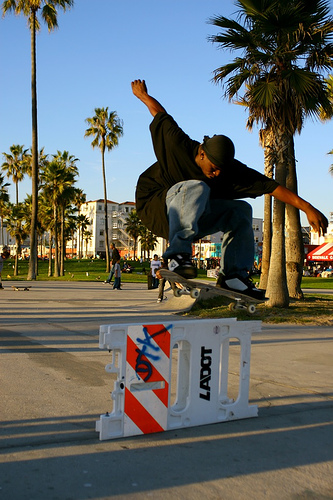

In [62]:
from adic_components.validation_utils import evaluate_model
def add_bos_eos(token_ids: torch.Tensor, bos_token_id: int, eos_token_id: int) -> torch.Tensor:
    bos = torch.full((token_ids.size(0), 1), bos_token_id, dtype=token_ids.dtype, device=token_ids.device)
    eos = torch.full((token_ids.size(0), 1), eos_token_id, dtype=token_ids.dtype, device=token_ids.device)
    return torch.cat([bos, token_ids, eos], dim=1)
with torch.no_grad():
    img, caption = dataset_sampling[random.randint(0, len(dataset_sampling.captions)-1)]
    tokenized_captions = tokenizer(caption, padding=True, return_tensors="pt", add_special_tokens=True).input_ids
    tokenized_captions = add_bos_eos(tokenized_captions, tokenizer.bos_token_id, tokenizer.eos_token_id)
    img_pixel_values = default_transform(img).unsqueeze(0)
    img_pixel_values = img_pixel_values.to(device)
    decoder_output = model.generate(img_pixel_values, max_length=25)
    generated = tokenizer.batch_decode(decoder_output.cpu().tolist(), skip_special_tokens=True)
    print(caption)
    print(generated)
    meteor = evaluate_model(model, img, caption, tokenizer)
    print("Meteor score: ", meteor)
img

<|endoftext|>A cat sitting on a bed with a book.     


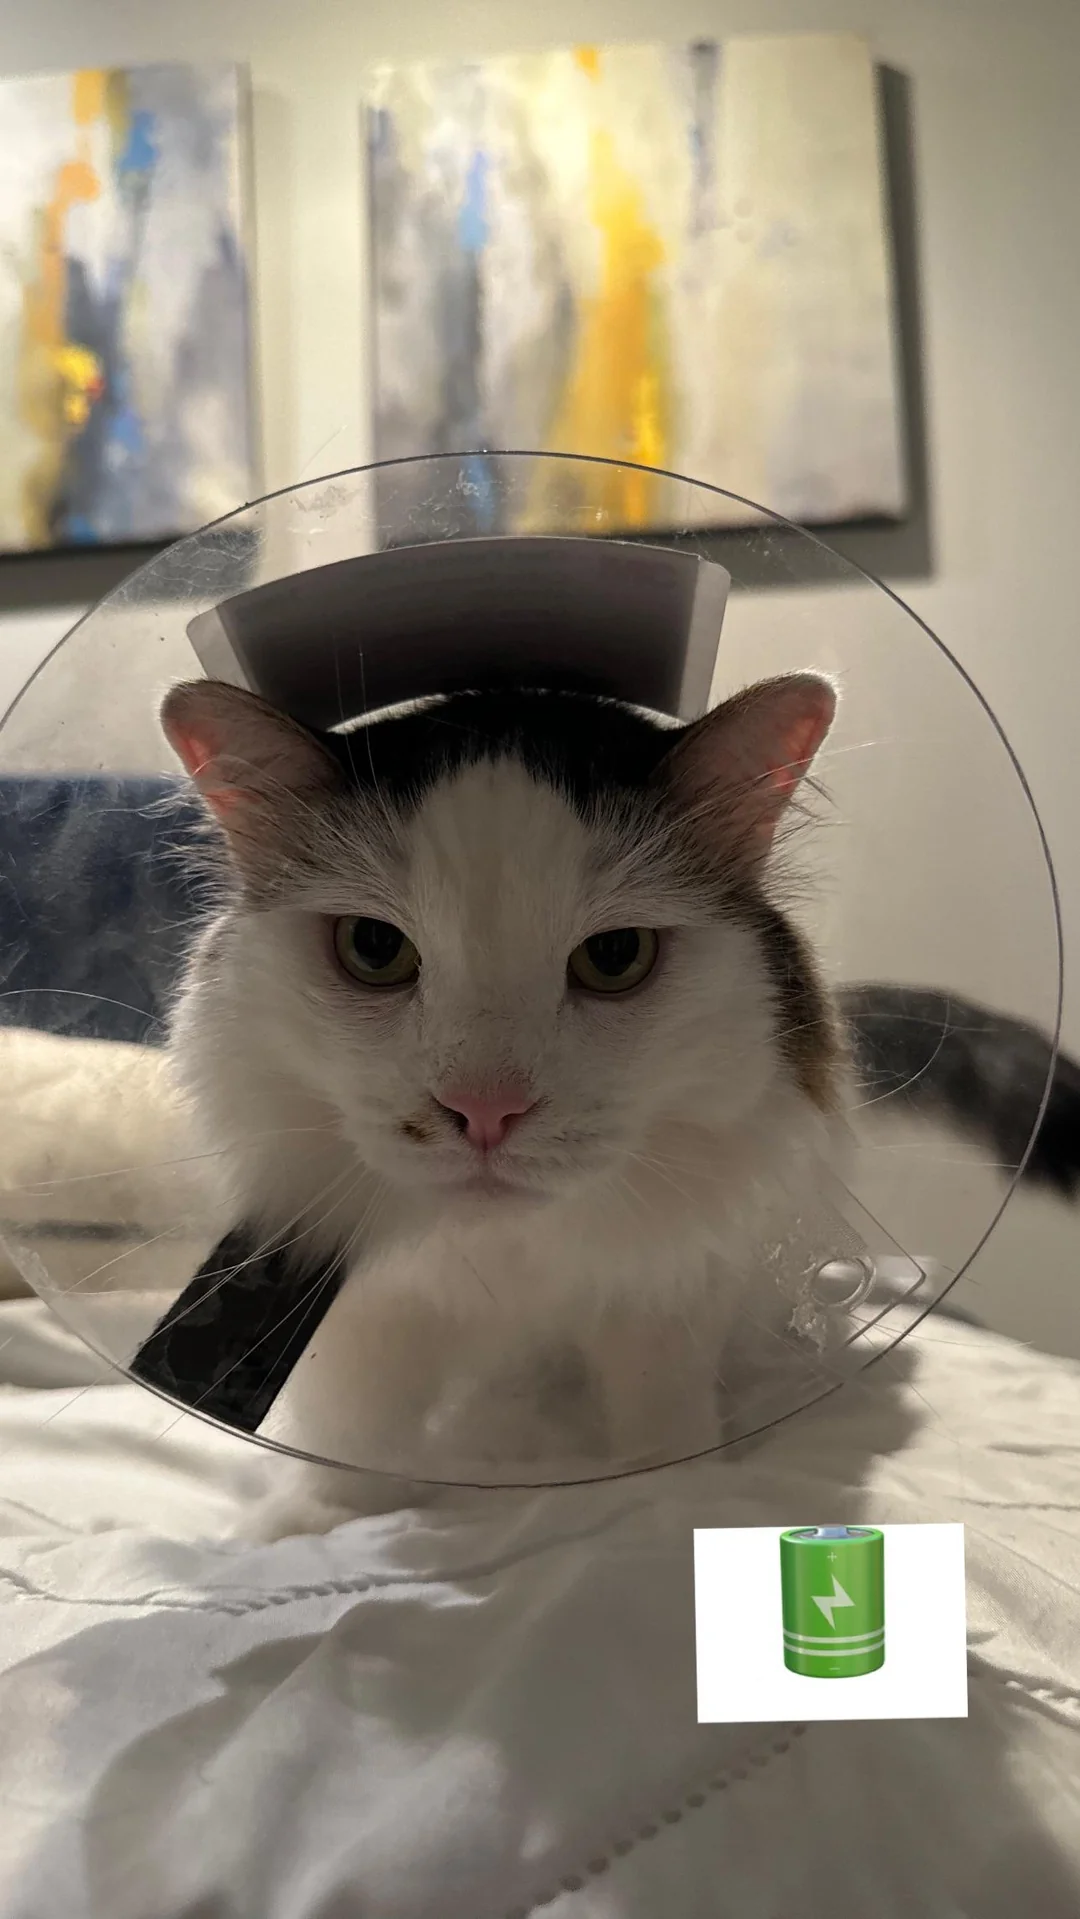

In [ ]:
from PIL import Image

img = Image.open('./validation/0/image.6.png')
org = img.copy()
img_pixel_values = default_transform(img).unsqueeze(0)
img_pixel_values = img_pixel_values.to(device)
decoder_output = model.generate(img_pixel_values)
generated = tokenizer.batch_decode(decoder_output.cpu())[0]
print(generated)
org

In [35]:
%reload_ext autoreload
%autoreload 2
from adic_components.validation_utils import compute_meteor_score
print(f'{compute_meteor_score("pred", "masa")}')

0.0
